In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the CSV file with mixed data types warning handled
df = pd.read_csv('DATA.csv', delimiter=',', low_memory=False)

# Create a dictionary to store the dataframes
asset_dict = {}

# List of assets and their corresponding date columns
assets = {
    'Brent': 'DATEBrent',
    'CrudeOilWTI': 'DATECrudeOilWTI',
    'Gold': 'DATEGold',
    'Silver': 'DATESilver',
    'HenryHub': 'DATEHenryHub',
    'Wheat': 'DATEWheat',
    'Soybeans': 'DATESoybeans',
    'HeatingOil': 'DATEHeatingOil',
    'LiveCattle': 'DATELiveCattle',
    'FeederCattle': 'DATEFeederCattle',
    'Coffee': 'DATECoffee',
    'Cotton': 'DATECotton',
    'Sugar': 'DATESugar'
}

# Loop through each asset and create a dataframe with date as index
for asset, date_col in assets.items():
    asset_df = df[[date_col, asset]].dropna()
    asset_df.set_index(date_col, inplace=True)
    asset_dict[asset] = asset_df

# Convert the date index to datetime and set frequency
for asset, asset_df in asset_dict.items():
    asset_df.index = pd.to_datetime(asset_df.index, errors='coerce')
    
    # Check if the index has a frequency and set it if needed
    if asset_df.index.is_unique:  # Ensures no duplicate dates
        asset_df = asset_df.sort_index()  # Sort the dates
        asset_df = asset_df.asfreq('D')  # Set frequency as daily ('D') if the data is daily
    else:
        print(f"Warning: The index for {asset} is not unique, frequency might not be set.")

    asset_dict[asset] = asset_df


In [2]:
# Function to forecast volatility using SARIMAX
def forecast_volatility(df, steps):
    # Model parameters
    order = (1, 1, 1)
    seasonal_order = (0, 0, 0, 0)

    # Fit the SARIMAX model
    model = SARIMAX(df, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Forecast the next value
    forecast = model_fit.get_forecast(steps = steps)

    # Extract and return the forecasted mean value
    forecasted_value = forecast.predicted_mean
    return forecasted_value

In [3]:
def forecast_volatility_rolling_window(df, start_percentage, steps):
    forecasted_values = []
    start = int(len(df) * start_percentage)
    starting_values = df.iloc[:start]
    for i in range(starting_values.shape[0], df.shape[0]):
        forecasted_value = forecast_volatility(df.iloc[:i], steps)
        forecasted_values.append(forecasted_value)
    return forecasted_values

In [8]:
def calculate_rolling_volatility(df, start_percentage):
    rolling_volatility = []
    start = int(len(df) * start_percentage)
    starting_values = df.iloc[:start]

    for i in range(starting_values.shape[0], df.shape[0]):
        rolling_vol = df.iloc[:i].std()
        rolling_volatility.append(rolling_vol)
    
    # Convert the list of rolling volatilities to a DataFrame
    rolling_volatility_df = pd.DataFrame(rolling_volatility, index=df.index[start:])
    return rolling_volatility_df

In [9]:
roll_percent = 0.7
gold_vol = calculate_rolling_volatility(asset_dict['Gold'], roll_percent)

In [ ]:
forcasted_gold = forecast_volatility_rolling_window(gold_vol, roll_percent, 5)

c:\Users\mathy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mathy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mathy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mathy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mathy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

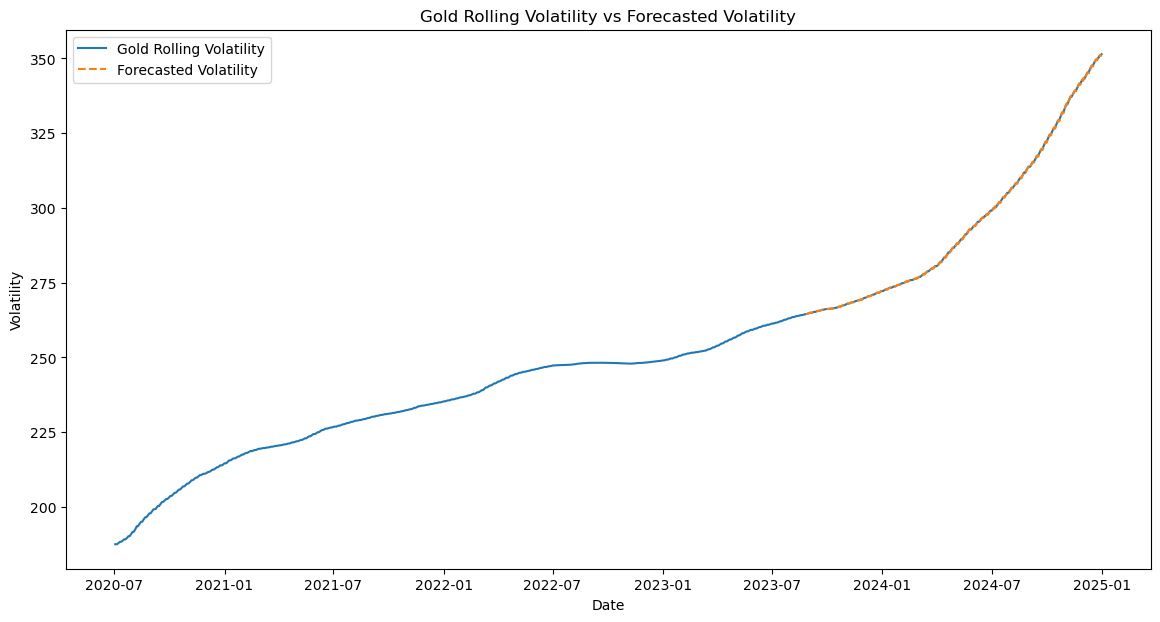

In [12]:
import matplotlib.pyplot as plt

# Convert gold_vol to a DataFrame for easier plotting
gold_vol_df = pd.DataFrame(gold_vol)

# Plot the rolling volatility
plt.figure(figsize=(14, 7))
plt.plot(gold_vol_df, label='Gold Rolling Volatility')

# Plot the forecasted volatility
forcasted_gold_df = pd.concat(forcasted_gold)
plt.plot(forcasted_gold_df.index, forcasted_gold_df.values, label='Forecasted Volatility', linestyle='--')

plt.title('Gold Rolling Volatility vs Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()